# Correlation between Total Blocking Time and Interaction to Next Paint on Mobile

One concern many web performance experts have about [First Input Delay](https://web.dev/fid) (FID) is that it doesn't capture enough of the user experience problems caused by main thread blocking JavaScript. We believe that [Interaction to Next Paint](https://web.dev/inp) (INP) better captures the user impact of main thread blocking JavaScript by capturing more of the time the user waits after an interaction.

Both these metrics are primarily field measurements (because you require actual User interactions), and not generally available in lab measurements of performance (unless you automate [User Flows](https://web.dev/lighthouse-user-flows/)).  The best lab metric for predicting field responsiveness has been [Total Blocking Time](https://web.dev/tbt) (TBT).


Now that we have some per-URL mobile CrUX data for INP in [HTTP Archive](https://httparchive.org/), we can correlate the [Total Blocking Time](https://web.dev/tbt) (TBT) from HTTP Archive's mobile `lighthouse` table with the per-URL 75th percentile INP and FID scores in the `pages` table. We see that there is a higher correlation between INP and TBT than INP and FID; when lighthouse measures more time spent blocking the main thread during load, the INP score tends to be worse. There could be multiple reasons for this:
* INP measures all interactions with the page, not just the first. If the main thread is not busy during the first interaction but busy during a later one, this will be captured by INP and not FID.
* Both FID and INP are slowed when the main thread is busy as the user presses a key, clicks the mouse, or touches their finger to start an interction. But only INP also will be slowed if main thread tasks are again run before the user lifts their finger.
* Pages with more main thread blocking JavaScript during load have more JavaScript running in general, and often this slows the event handlers which are measured by INP and not FID.

For all these reasons, we believe that reducing your site's TBT in [Lighthouse](https://developers.google.com/web/tools/lighthouse) and following its recommendations to [reduce JavaScript execution time](https://web.dev/bootup-time/) and [minimize main thread work](https://web.dev/mainthread-work-breakdown/) are good first steps to improving your site's INP.

In this run, we only had data for just under 800,000 URLs due to a pipeline issue. A previous internal study on over 3 million URLs saw a similar correlation between INP and TBT, and a weaker correlation between TBT and FID.

# Get the data from HTTP Archive

In [ ]:
#@markdown # Setup
#@markdown Authenticate in order to use bigquery
import altair as alt
import pandas as pd
import numpy as np
from scipy import stats
from google.colab import auth
auth.authenticate_user()

In [ ]:
#@markdown Use the ``google.colab.data_table`` package to display large pandas dataframes as an interactive data table.
%load_ext google.colab.data_table

In [ ]:
#@markdown ## Query HTTP Archive for INP and FID from pages table.
#@markdown The pages table contains data from CrUX API for each page; it's the
#@markdown easiest place to query from.
%%bigquery --project httparchive-project-for-annie fid_inp
  SELECT
    url,
    CAST(JSON_QUERY(payload, "$._CrUX.metrics.first_input_delay.percentiles.p75") AS float64) AS fid,
    CAST(JSON_QUERY(payload, "$._CrUX.metrics.experimental_interaction_to_next_paint.percentiles.p75") AS float64) AS inp,
  FROM
    `httparchive.pages.2022_05_01_mobile`
  WHERE
    JSON_QUERY(payload, "$._CrUX.metrics.experimental_interaction_to_next_paint.percentiles.p75") IS NOT NULL

In [ ]:
#@markdown ## Query HTTP Archive for TBT from lighthouse table.
#@markdown The lighthouse table contains TBT scores from each run
%%bigquery --project httparchive-project-for-annie tbt
  SELECT
    JSON_EXTRACT_SCALAR(report, '$.finalUrl') AS url,
    # There can be multiple values for TBT because multiple origins redirect to
    # the same URL. Take the median in this case.
    APPROX_QUANTILES(CAST(JSON_QUERY(report, "$.audits.total-blocking-time.numericValue") AS float64), 100)[OFFSET(50)] AS tbt
  FROM
    `httparchive.lighthouse.2022_05_01_mobile`
  WHERE
    JSON_QUERY(report, "$.audits.total-blocking-time.numericValue") IS NOT NULL
  GROUP BY url

In [ ]:
#@markdown ## Merge TBT, FID, and INP data into one pandas dataframe
#@markdown We could have done a join in the query, but sometimes it's easy
#@markdown just to use pandas.
#@markdown
#@markdown *Note: because sometimes multiple origins redirect to the same URL,
#@markdown there were some duplicate URLs in the lighthouse table. We drop
#@markdown duplicate TBTs.*
metrics = pd.merge(tbt, fid_inp, on='url')

# What does the data look like?

In [ ]:
#@markdown ## How much data do we have?
#@markdown The CrUX API was called and TBT was calculated for almost 800,000 URLs.
metrics.shape[0]

781509

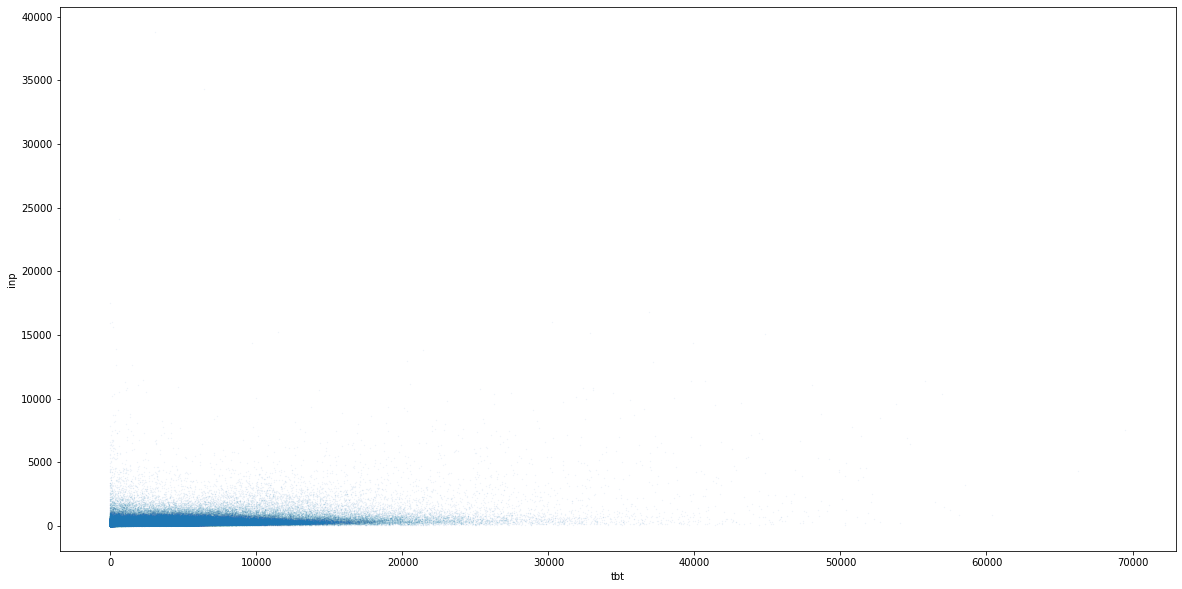

In [ ]:
#@markdown ## What does a plot of TBT vs INP look like?
#@markdown Seems like most of the data points are below ~7500 INP and ~40000 TBT
#@markdown but there are some outliers that make it hard to see anything!
metrics.plot.scatter(x='tbt', y='inp', s=0.1, alpha=0.1, figsize=(20, 10))

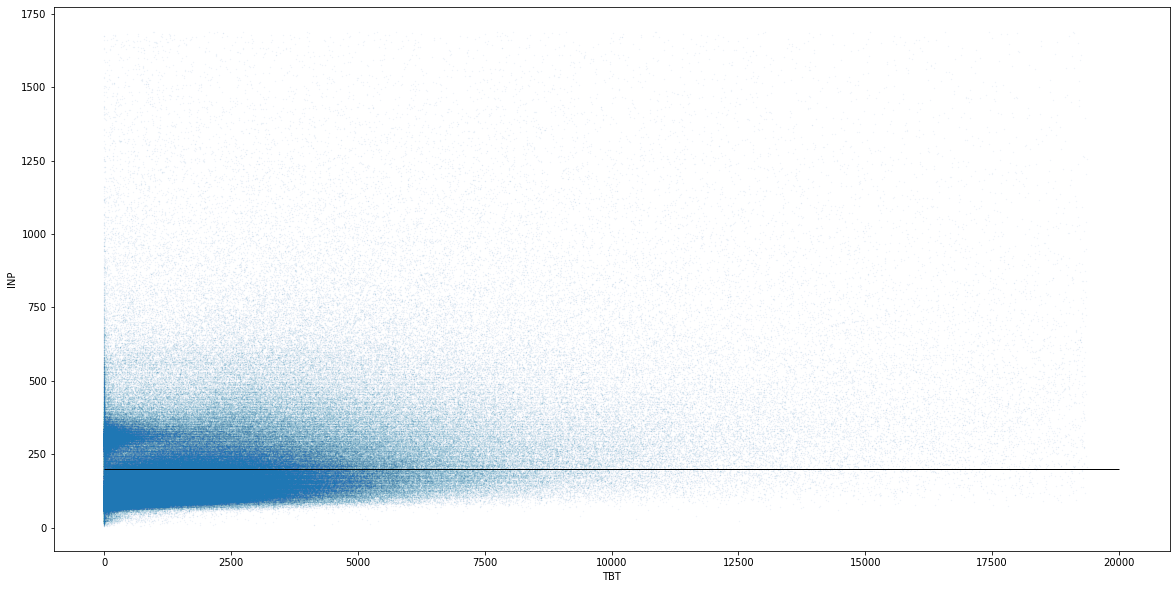

In [ ]:
#@markdown ## Remove outliers: INP
#@markdown Trim the top 0.5% of values, and show "good" INP threshold.
#@markdown
#@markdown The triangle cluster starting around (0 TBT, 300 INP) appears to be due to
#@markdown [tap delay](https://developer.chrome.com/blog/300ms-tap-delay-gone-away/)
#@markdown on sites that do not have a `<meta viewport>` tag.
high_tbt_val = metrics.tbt.quantile(0.995)
high_inp_val = metrics.inp.quantile(0.995)
trimmed_metrics = metrics[
                          (metrics.tbt < high_tbt_val) &
                          (metrics.inp < high_inp_val)]
import matplotlib.pyplot as plt

ax = plt.axes()
ax.figure.set_figheight(10)
ax.figure.set_figwidth(20)

ax.set_xlabel('TBT')
ax.set_ylabel('INP')

ax.scatter(x=trimmed_metrics.tbt, y=trimmed_metrics.inp, s=0.1, alpha=0.1)
ax.hlines(200, 0, 20_000, color='k', linewidth=1)

plt.show()

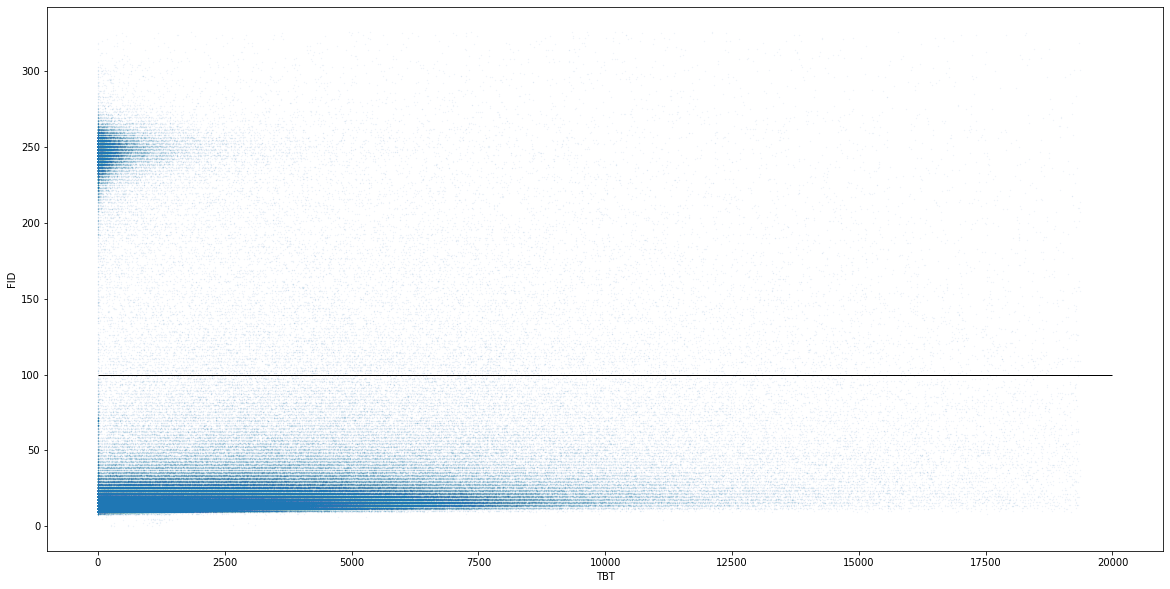

In [ ]:
#@markdown ## Remove outliers: FID
#@markdown Same chart with FID, for comparison.
#@markdown As above, the upper left cluster appears to be due to
#@markdown [tap delay](https://developer.chrome.com/blog/300ms-tap-delay-gone-away/)
#@markdown on sites that do not have a `<meta viewport>` tag.
high_tbt_val = metrics.tbt.quantile(0.995)
high_fid_val = metrics.fid.quantile(0.995)
trimmed_metrics = metrics[(metrics.tbt < high_tbt_val) &
                          (metrics.fid < high_fid_val)]

ax = plt.axes()
ax.figure.set_figheight(10)
ax.figure.set_figwidth(20)

ax.set_xlabel('TBT')
ax.set_ylabel('FID')

ax.scatter(x=trimmed_metrics.tbt, y=trimmed_metrics.fid, s=0.1, alpha=0.1)
ax.hlines(100, 0, 20_000, color='k', linewidth=1)

plt.show()

# Exclude sites with problems caused by not setting viewport

In [ ]:
#@markdown Can we find all the sites whose Lighthouse audits say their lack of
#@markdown `<meta viewport>` tags cause a slowdown, and exclude them, so that
#@markdown we can more clearly look at sites whose INP/FID is slowed by
#@markdown other factors?
%%bigquery --project httparchive-project-for-annie viewport
  SELECT
    JSON_EXTRACT_SCALAR(report, '$.finalUrl') AS url,
    # There can be multiple values for the viewport audit because multiple
    # origins redirect to the same URL. Take the max in this case, assuming that
    # if one of the tests passed, that was the most accurate.
    MAX(CAST(JSON_QUERY(report, "$.audits.viewport.score") AS int64)) AS viewport
  FROM
    `httparchive.lighthouse.2022_05_01_mobile`
  WHERE
    JSON_QUERY(report, "$.audits.viewport.score") IS NOT NULL
  GROUP BY url

In [ ]:
#@markdown Merge the viewport data into our data frame.
#@markdown We are requiring a score for the viewport audit;
#@markdown how many data points are there after removing sites
#@markdown with no score?
#@markdown
#@markdown Still nearly 800,000.
metrics_viewport = pd.merge(metrics, viewport, on='url')
metrics_viewport.shape[0]

781509

In [ ]:
#@markdown How many data points are left if we remove the rows with no
#@markdown `<meta viewport>` set?
#@markdown
#@markdown As expected, most of the data points have a correct viewport tag;
#@markdown less than 50,000 rows removed.
metrics_has_viewport = metrics_viewport[metrics_viewport.viewport == 1]
metrics_has_viewport.shape[0]

733439

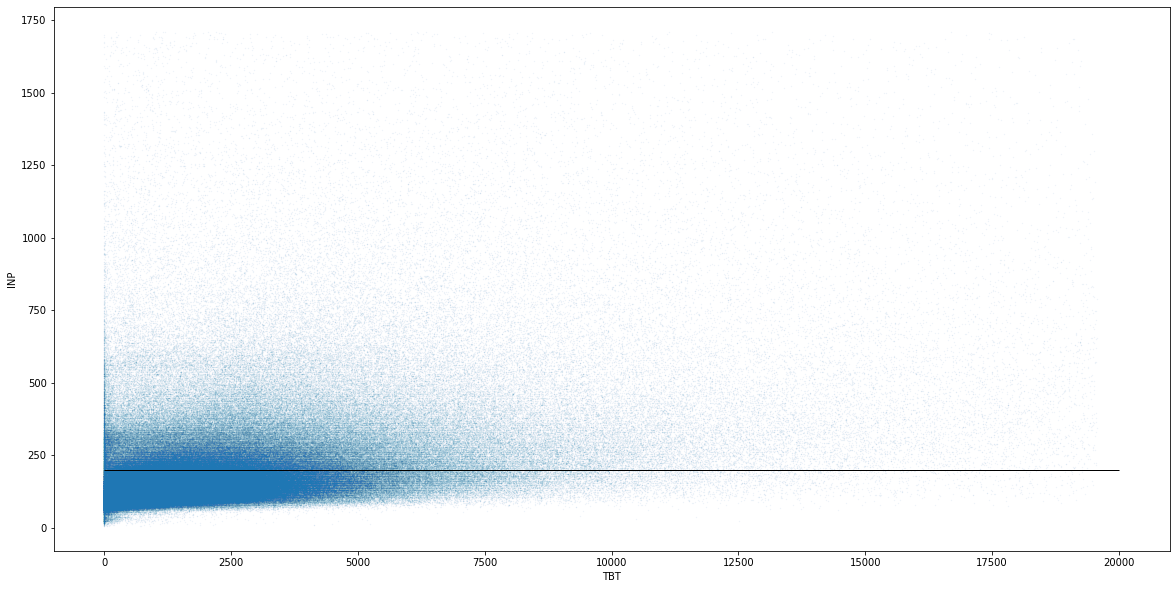

In [ ]:
#@markdown ## Updated plot: INP
#@markdown Plotting TBT vs INP with sites not specifying a viewport removed,
#@markdown we see the triangle-shaped cluster on the left is much less dense.
high_tbt_val = metrics_has_viewport.tbt.quantile(0.995)
high_inp_val = metrics_has_viewport.inp.quantile(0.995)
trimmed_metrics = metrics_has_viewport[(metrics_has_viewport.tbt < high_tbt_val) &
                                       (metrics_has_viewport.inp < high_inp_val)]

ax = plt.axes()
ax.figure.set_figheight(10)
ax.figure.set_figwidth(20)

ax.set_xlabel('TBT')
ax.set_ylabel('INP')

ax.scatter(x=trimmed_metrics.tbt, y=trimmed_metrics.inp, s=0.1, alpha=0.1)
ax.hlines(200, 0, 20_000, color='k', linewidth=1)

plt.show()

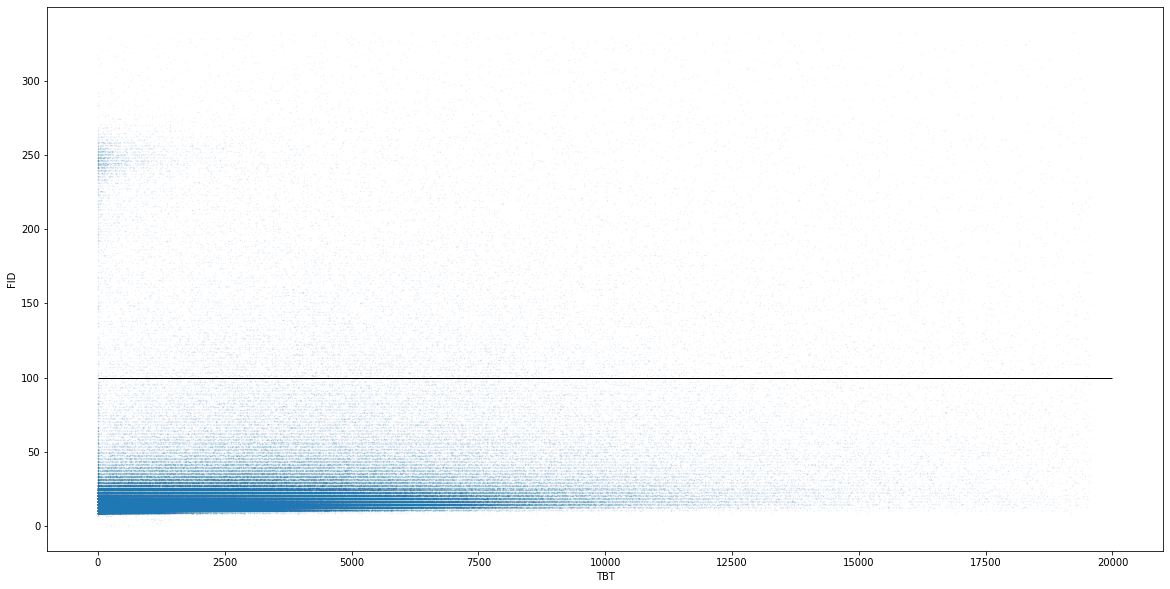

In [ ]:
#@markdown ## Updated Plot: FID
#@markdown Plotting TBT vs FID with sites not specifying a viewport removed,
#@markdown we see the triangle-shaped cluster on the left is also much less dense.
high_tbt_val = metrics_has_viewport.tbt.quantile(0.995)
high_fid_val = metrics_has_viewport.fid.quantile(0.995)
trimmed_metrics = metrics_has_viewport[(metrics_has_viewport.tbt < high_tbt_val) &
                                       (metrics_has_viewport.fid < high_fid_val)]

ax = plt.axes()
ax.figure.set_figheight(10)
ax.figure.set_figwidth(20)

ax.set_xlabel('TBT')
ax.set_ylabel('FID')

ax.scatter(x=trimmed_metrics.tbt, y=trimmed_metrics.fid, s=0.1, alpha=0.1)
ax.hlines(100, 0, 20_000, color='k', linewidth=1)

plt.show()

# How does TBT relate to INP?

In [ ]:
#@markdown Remove outliers and only look at sites with a viewport
#@markdown set correctly.
high_tbt_val = metrics_has_viewport.tbt.quantile(0.995)
high_inp_val = metrics_has_viewport.inp.quantile(0.995)
high_fid_val = metrics_has_viewport.fid.quantile(0.995)
trimmed_metrics = metrics_has_viewport[(metrics_has_viewport.tbt < high_tbt_val) &
                                       (metrics_has_viewport.inp < high_inp_val) &
                                       (metrics_has_viewport.fid < high_fid_val)]

## Correlation between TBT and INP, TBT and FID

We see that both INP and FID are correlated to TBT. Sites with more main thread blocking JavaScript score worse on both metrics. INP is _more_ correlated to TBT than FID, so sites with more main blocking time have worse INP scores more often than they have worse FID scores.

But INP is only a _little_ more correlated to TBT than FID. Have we gotten ourselves in another situation where the guidance on blocking the main thread in Lighthouse can be ignored? We believe not: we think instead the _threshold_ for good FID was low enough that many sites could achieve a "good" FID score without paying attention to problems with JavaScript blocking the main thread. See tables in next section.

In [ ]:
#@markdown ## Kendall correlation between TBT and FID/INP
trimmed_metrics.corr(method='kendall')

,tbt,fid,inp
tbt,1.000000,0.285720,0.339882
fid,0.285720,1.000000,0.445028
inp,0.339882,0.445028,1.000000


In [ ]:
#@markdown ## Spearman correlation between TBT and FID/INP
trimmed_metrics.corr(method='spearman')

,tbt,fid,inp
tbt,1.000000,0.402110,0.484315
fid,0.402110,1.000000,0.602388
inp,0.484315,0.602388,1.000000


In [ ]:
#@markdown ## Pearson correlation between TBT and FID/INP
#@markdown I've included this for completion, but
#@markdown Pearson's correlation wasn't meant for data like this!
#@markdown ([More information on why](https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php#assumptions4-7))
trimmed_metrics.corr(method='pearson')

,tbt,fid,inp
tbt,1.000000,0.305472,0.410956
fid,0.305472,1.000000,0.495790
inp,0.410956,0.495790,1.000000


## Table: Percent meeting "good" threshold for INP and FID by TBT value

In [ ]:
#@markdown For each 500ms bucket of TBT scores in lighthouse, 
#@markdown What percent of sites meet the current "good" INP
#@markdown threshold of 200ms, and the current "good" threshold
#@markdown of 100ms for FID?
#@markdown
#@markdown It's definitely possible to have a very good TBT score
#@markdown and INP that isn't good. It's also possible to have a
#@markdown very high TBT score and INP that is good.
#@markdown
#@markdown But we see a clear trend that sites with better TBT
#@markdown are more likely to have good INP.
rows = []
for tbt in range(0, 19000, 500):
  count_meets_inp = trimmed_metrics[(trimmed_metrics.tbt >= tbt) &
                                    (trimmed_metrics.tbt < tbt + 500) &
                                    (trimmed_metrics.inp <= 200)].shape[0]
  count_meets_fid = trimmed_metrics[(trimmed_metrics.tbt >= tbt) &
                                    (trimmed_metrics.tbt < tbt + 500) &
                                    (trimmed_metrics.fid <= 100)].shape[0]
  total_count = trimmed_metrics[(trimmed_metrics.tbt >= tbt) &
                                (trimmed_metrics.tbt < tbt + 500)].shape[0]
  rows.append({
      'TBT': tbt,
      '% in bucket meeting good INP threshold': count_meets_inp / total_count * 100,
      '% in bucket meeting good FID threshold': count_meets_fid / total_count * 100,
      'Sites in bucket': total_count,
  })
pd.DataFrame(rows)

,TBT,% in bucket meeting good INP threshold,% in bucket meeting good FID threshold,Sites in bucket
0,0,84.906307,98.166133,122528
1,500,82.827960,98.840340,96925
2,1000,77.511628,98.916748,80406
3,1500,71.771859,98.808448,65293
4,2000,65.900723,98.468113,54051
5,2500,60.243593,98.176393,44911
6,3000,55.732854,97.779314,36160
7,3500,50.912247,97.365375,29378
8,4000,46.563832,96.802107,23922
9,4500,43.801272,96.128999,19504


# Why not just lower the FID threshold?

There are a lot of problems with this approach. Here are a few:
1. Our focus is the user experience. Looking at the chart below, we'd probably want to make the threshold somewhere between 10-25ms. There is no basis in user experience research for such a low value for discrete interactions. Conversely, the new INP metric measures _more_ of the user experience, and its values are more closely tied to the experiences we see recommendations for thresholds around in user experience research.
2. Changing FID threshold doesn't solve any of these issues on desktop, where FID is nearly always 0.
3. INP is more correlated to TBT than FID. Looking at the table of FID and INP pass rates broken down by TBT, the INP metric drops off more quickly than FID as TBT increases.

In [ ]:
rows = []
for tbt in range(0, 19000, 500):
  count_meets_inp = trimmed_metrics[(trimmed_metrics.tbt >= tbt) &
                                    (trimmed_metrics.tbt < tbt + 500) &
                                    (trimmed_metrics.inp <= 200)].shape[0]
  count_meets_fid_10 = trimmed_metrics[(trimmed_metrics.tbt >= tbt) &
                                       (trimmed_metrics.tbt < tbt + 500) &
                                       (trimmed_metrics.fid <= 10)].shape[0]
  count_meets_fid_25 = trimmed_metrics[(trimmed_metrics.tbt >= tbt) &
                                        (trimmed_metrics.tbt < tbt + 500) &
                                        (trimmed_metrics.fid <= 25)].shape[0]
  count_meets_fid_50 = trimmed_metrics[(trimmed_metrics.tbt >= tbt) &
                                       (trimmed_metrics.tbt < tbt + 500) &
                                       (trimmed_metrics.fid <= 50)].shape[0]
  count_meets_fid_100 = trimmed_metrics[(trimmed_metrics.tbt >= tbt) &
                                        (trimmed_metrics.tbt < tbt + 500) &
                                        (trimmed_metrics.fid <= 100)].shape[0]
  total_count = trimmed_metrics[(trimmed_metrics.tbt >= tbt) &
                                (trimmed_metrics.tbt < tbt + 500)].shape[0]
  rows.append({
      'TBT': tbt,
      '% good INP': count_meets_inp / total_count * 100,
      '% FID under 10': count_meets_fid_10 / total_count * 100,
      '% FID under 25': count_meets_fid_25 / total_count * 100,
      '% FID under 50': count_meets_fid_50 / total_count * 100,
      '% FID under 100': count_meets_fid_100 / total_count * 100,
      'Sites in bucket': total_count,
  })
pd.DataFrame(rows)

,TBT,% good INP,% FID under 10,% FID under 25,% FID under 50,% FID under 100,Sites in bucket
0,0,84.906307,10.017302,93.495364,97.280622,98.166133,122528
1,500,82.827960,8.410627,93.417591,97.769409,98.840340,96925
2,1000,77.511628,5.954779,92.333905,97.562371,98.916748,80406
3,1500,71.771859,4.193405,90.766238,97.053283,98.808448,65293
4,2000,65.900723,3.148878,88.534902,96.038926,98.468113,54051
5,2500,60.243593,2.360224,85.486852,95.123689,98.176393,44911
6,3000,55.732854,1.839049,82.613385,93.974004,97.779314,36160
7,3500,50.912247,1.358159,80.148410,92.879025,97.365375,29378
8,4000,46.563832,1.045063,76.996071,91.526628,96.802107,23922
9,4500,43.801272,0.794709,73.282404,89.837982,96.128999,19504
